In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
df=pd.read_excel('processedfinal.xlsx')

In [2]:
dfp=df 
dfp

,id,city,brand,name,year,price,body,engine,fuel,mileage,...,tires_p_indicator,air_suspension,changing_clearance,freshly_imported,freshly_delivered,tax_payed,tech_passed,no_invest,cantgo,score
0,138509241,Атырау,Lexus,GX 470,2006,9000000,внедорожник,4.7,бензин,220000.0,...,1,1,1,1,1,1,1,1,0,65
1,136134634,Алматы,Toyota,Land Cruiser Prado,2006,6250000,внедорожник,3.0,дизель,303050.0,...,0,0,0,0,0,0,0,0,0,1
2,137275031,Алматы,Jeep,Grand Cherokee,2006,7300000,внедорожник,4.7,бензин,NaN,...,1,0,0,0,0,1,1,0,0,22
3,136825416,Алматы,Toyota,Camry,2006,4776150,седан,2.4,бензин,NaN,...,0,0,0,0,0,0,0,0,0,0
4,138236492,Шымкент,Ford,Focus,2006,1900000,седан,1.6,бензин,320000.0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179058,138612753,Нур-Султан (Астана),ВАЗ (Lada),2114 (хэтчбек),2006,1000000,хэтчбек,1.6,бензин,NaN,...,0,0,0,0,0,0,0,0,0,0
179059,138612412,Караганда,Toyota,Land Cruiser Prado,2006,9800000,внедорожник,2.7,бензин,250000.0,...,0,0,0,0,0,1,1,1,0,25
179060,138612527,Актобе,Toyota,Mark X,2006,3100000,седан,2.5,бензин,NaN,...,0,0,0,0,0,0,0,0,0,0
179061,138612059,Нур-Султан (Астана),Subaru,Tribeca,2006,6200000,кроссовер,3.0,бензин,230087.0,...,1,0,0,0,0,1,1,1,0,37


In [3]:
#delete all rows with price > 200000000
dfp=dfp[dfp['price']<100000000]
dfp=dfp[dfp['price']>1000000]

dfp['age']=2022 - dfp['year']

#if cantgo = 1 drop row
dfp=dfp[dfp['cantgo']==0]
dfp.drop('cantgo', axis=1, inplace=True)

In [4]:
#drop city
dfp.dropna(subset=['city'], inplace=True)

In [5]:
dfp['engine']=dfp['engine'].astype(str)
dff = dfp.groupby(['brand', 'name', 'year', 'engine',])['price'].mean()
# dff = dfp.groupby(['brand', 'name', 'year', 'engine',])['price'].mean().reset_index() #calculate mean of prices by brand name year and engine
dff.to_excel('average.xlsx')


In [6]:
#if price 20% less or more than average delete row
dfp['need_invest']=0
dfp['need_invest']=dfp['need_invest'].astype(int)

dfp.reset_index(drop=True, inplace=True)
for i in range(len(dfp)):
    if (dfp.loc[i,'price']<(dff.loc[(dfp.loc[i,'brand'],dfp.loc[i,'name'],dfp.loc[i,'year'],dfp.loc[i,'engine'])]*0.7) or dfp.loc[i,'price']>(dff.loc[(dfp.loc[i,'brand'],dfp.loc[i,'name'],dfp.loc[i,'year'],dfp.loc[i,'engine'])]*1.3)):
         dfp.loc[i,'need_invest']=1
    else:
        dfp.loc[i,'need_invest']=0

#if need_invest = 1 drop row
dfp=dfp[dfp['need_invest']==0]
dfp.drop('need_invest', axis=1, inplace=True)

In [7]:
dfp['engine']=dfp['engine'].replace('nan','Nan')
dfp['engine']=dfp['engine'].astype(float)

<function matplotlib.pyplot.show(close=None, block=None)>

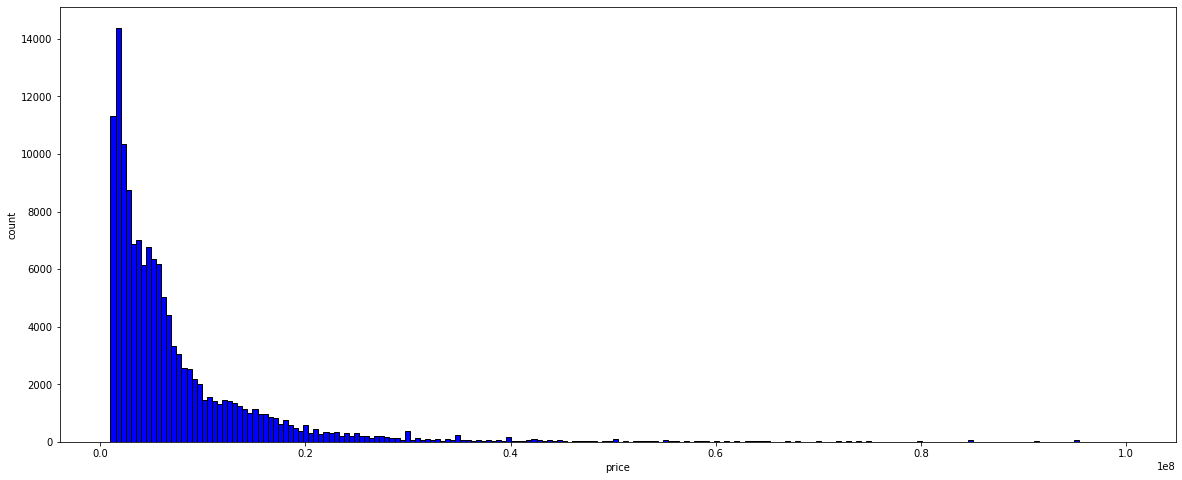

In [8]:
plt.figure(figsize=(20,8))
plt.hist(dfp['price'], bins=200, color='blue', edgecolor='black')
#увеличить количество делений по x на 10
plt.xlabel('price')
plt.ylabel('count')
plt.show

In [9]:
dfp.drop('age', axis=1, inplace=True)
dfp.drop('city', axis=1, inplace=True)
dfp.drop('id', axis=1, inplace=True)

In [10]:
categorial_features = ['brand', 'name', 'body', 'fuel', 'transmission', 'drive', 'wheel', 'color']

for i in range (12,87):
    #convert to bool
    categorial_features.append(dfp.columns[i])
    dfp.iloc[:,i]=dfp.iloc[:,i].astype('category')

categorial_features

['brand',
 'name',
 'body',
 'fuel',
 'transmission',
 'drive',
 'wheel',
 'color',
 'cleared_in_kz',
 'vin',
 'disks',
 'toning',
 'visor',
 'baggage',
 'daytime_lights',
 'fog_lights',
 'velour',
 'audio_system',
 'phone',
 'bluetooth',
 'cd',
 'mp3',
 'usb',
 'dvd',
 'hydr_wheel_bust',
 'abs',
 'signaling',
 'autorun',
 'spoiler',
 'hood',
 'lift',
 'roof_panoram',
 'luke',
 'body_kit',
 'roof_rails',
 'hitch',
 'xenon',
 'bixenon',
 'hr_optic',
 'lins_optic',
 'light_washer',
 'linght_corr',
 'mirror_heat',
 'leather',
 'wood',
 'alkantara',
 'combined',
 'blinds',
 'dvd_changer',
 'subbufer',
 'srs',
 'winter_mode',
 'sport_mode',
 'turbo_charging',
 'turbotimer',
 'immobilizer',
 'keyless_access',
 'full_el_power',
 'cent_lock',
 'air_conditioning',
 'climat_control',
 'cruis_control',
 'bort_pc',
 'navigation',
 'multi_wheel',
 'wheel_heat',
 'seats_heats',
 'back_seats_heats',
 'seats_venting',
 'seats_memory',
 'wheel_memory',
 'parktroniks',
 'back_camera',
 'light_indicator'

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
dfp['brand']=dfp['brand'].astype('category')
dfp['name']=dfp['name'].astype('category')
dfp['body']=dfp['body'].astype('category')
dfp['fuel']=dfp['fuel'].astype('category')
dfp['transmission']=dfp['transmission'].astype('category')
dfp['drive']=dfp['drive'].astype('category')
dfp['wheel']=dfp['wheel'].astype('category')
dfp['color']=dfp['color'].astype('category')

cetegorial_trasformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numerical_features = ['year', 'engine', 'price','engine','score']
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', cetegorial_trasformer, categorial_features),
        ('numerical', numerical_transformer, numerical_features)
    ])


In [12]:
clf = Pipeline(steps=[{'preprocessor': preprocessor, 'regressor': lgb.LGBMRegressor(),}])

In [13]:
y=pd.DataFrame (dfp['price'])
# y = dfp['price']
x = dfp.drop(columns=['price'])
#split data to train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1254)

train_dataset = lgb.Dataset(x_train, y_train)
test_dataset = lgb.Dataset(x_test, y_test, reference=train_dataset)

In [14]:

params = {
    'num_boost_round': 300,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mape', 
    'num_leaves': 250,
    'learning_rate': 0.07,
    'feature_fraction': 0.7,
    'verbosity': -1,
    }
# # Обучаем модель:
# booster = lgb.train(
#     params=params, 
#     train_set=train_dataset,
#     valid_sets=[train_dataset, test_dataset],
#     valid_names=['train', 'valid'],
#     # verbose_eval=False
#     )

In [49]:

booster = lgb.LGBMRegressor(
    **params, 
    valid_sets=[train_dataset, test_dataset],
    valid_names=['train', 'valid'],
    # verbose_eval=False
    )

In [50]:
booster.fit(x_train, y_train, verbose=True, 
            eval_set=[(x_test, y_test)],
            eval_metric="mape")

C:\Users\drags\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\drags\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


C:\Users\drags\AppData\Roaming\Python\Python310\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\drags\AppData\Roaming\Python\Python310\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's mape: 1.29349
[2]	valid_0's mape: 1.22881
[3]	valid_0's mape: 1.1482
[4]	valid_0's mape: 1.07269
[5]	valid_0's mape: 1.0026
[6]	valid_0's mape: 0.937244
[7]	valid_0's mape: 0.884585
[8]	valid_0's mape: 0.827384
[9]	valid_0's mape: 0.775719
[10]	valid_0's mape: 0.732116
[11]	valid_0's mape: 0.691945
[12]	valid_0's mape: 0.648659
[13]	valid_0's mape: 0.617274
[14]	valid_0's mape: 0.578736
[15]	valid_0's mape: 0.542798
[16]	valid_0's mape: 0.509972
[17]	valid_0's mape: 0.479363
[18]	valid_0's mape: 0.451027
[19]	valid_0's mape: 0.424745
[20]	valid_0's mape: 0.400286
[21]	valid_0's mape: 0.382763
[22]	valid_0's mape: 0.362707
[23]	valid_0's mape: 0.345501
[24]	valid_0's mape: 0.327353
[25]	valid_0's mape: 0.310121
[26]	valid_0's mape: 0.296814
[27]	valid_0's mape: 0.281891
[28]	valid_0's mape: 0.26827
[29]	valid_0's mape: 0.257835
[30]	valid_0's mape: 0.246254
[31]	valid_0's mape: 0.235866
[32]	valid_0's mape: 0.229189
[33]	valid_0's mape: 0.220176
[34]	valid_0's mape: 0.2129

LGBMRegressor(feature_fraction=0.7, learning_rate=0.07, metric='mape',
              num_boost_round=300, num_leaves=250, objective='regression',
              verbosity=-1)

In [51]:
import dalex as dx
    
ex = dx.Explainer(
    booster,
    x_train,
    y_train
)

Preparation of a new explainer is initiated

  -> data              : 124974 rows 87 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 124974 values
  -> model_class       : lightgbm.sklearn.LGBMRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x0000018ED6E629E0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = -9.48e+04, mean = 7.35e+06, max = 9.66e+07
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -2.84e+07, mean = -3.5, max = 1.96e+07
  -> model_info        : package lightgbm

A new explainer has been created!


In [65]:
example=pd.DataFrame()
#select random row from dataframe

example = x_test.sample(n=1)
example.head()

,brand,name,year,body,engine,fuel,mileage,transmission,wheel,color,...,rain_indicator,tires_p_indicator,air_suspension,changing_clearance,freshly_imported,freshly_delivered,tax_payed,tech_passed,no_invest,score
663,Land Rover,Range Rover,2007,внедорожник,4.4,бензин,70000.0,автомат,слева,черный металлик,...,0,0,0,0,0,0,1,1,1,15


In [58]:
#x_test.info()
#print only categorical features
len(x_test.select_dtypes(include='category').columns.to_list())

83

In [40]:
x_test.select_dtypes(include='category').columns

Index(['brand', 'name', 'body', 'fuel', 'transmission', 'wheel', 'color',
       'drive', 'cleared_in_kz', 'vin', 'disks', 'toning', 'visor', 'baggage',
       'daytime_lights', 'fog_lights', 'velour', 'audio_system', 'phone',
       'bluetooth', 'cd', 'mp3', 'usb', 'dvd', 'hydr_wheel_bust', 'abs',
       'signaling', 'autorun', 'spoiler', 'hood', 'lift', 'roof_panoram',
       'luke', 'body_kit', 'roof_rails', 'hitch', 'xenon', 'bixenon',
       'hr_optic', 'lins_optic', 'light_washer', 'linght_corr', 'mirror_heat',
       'leather', 'wood', 'alkantara', 'combined', 'blinds', 'dvd_changer',
       'subbufer', 'srs', 'winter_mode', 'sport_mode', 'turbo_charging',
       'turbotimer', 'immobilizer', 'keyless_access', 'full_el_power',
       'cent_lock', 'air_conditioning', 'climat_control', 'cruis_control',
       'bort_pc', 'navigation', 'multi_wheel', 'wheel_heat', 'seats_heats',
       'back_seats_heats', 'seats_venting', 'seats_memory', 'wheel_memory',
       'parktroniks', 'back_ca

In [41]:
dfp.select_dtypes(include='category').columns

Index(['brand', 'name', 'body', 'fuel', 'transmission', 'wheel', 'color',
       'drive', 'cleared_in_kz', 'vin', 'disks', 'toning', 'visor', 'baggage',
       'daytime_lights', 'fog_lights', 'velour', 'audio_system', 'phone',
       'bluetooth', 'cd', 'mp3', 'usb', 'dvd', 'hydr_wheel_bust', 'abs',
       'signaling', 'autorun', 'spoiler', 'hood', 'lift', 'roof_panoram',
       'luke', 'body_kit', 'roof_rails', 'hitch', 'xenon', 'bixenon',
       'hr_optic', 'lins_optic', 'light_washer', 'linght_corr', 'mirror_heat',
       'leather', 'wood', 'alkantara', 'combined', 'blinds', 'dvd_changer',
       'subbufer', 'srs', 'winter_mode', 'sport_mode', 'turbo_charging',
       'turbotimer', 'immobilizer', 'keyless_access', 'full_el_power',
       'cent_lock', 'air_conditioning', 'climat_control', 'cruis_control',
       'bort_pc', 'navigation', 'multi_wheel', 'wheel_heat', 'seats_heats',
       'back_seats_heats', 'seats_venting', 'seats_memory', 'wheel_memory',
       'parktroniks', 'back_ca

In [32]:
len(x_train.select_dtypes(include='category').columns.to_list())

83

In [31]:
len(dfp.select_dtypes(include='category').columns.to_list())


83

In [66]:
ex.predict( example )

array([10559433.49367034])

In [69]:
pp=ex.predict_parts(example, type='break_down')

ValueError: train and valid dataset categorical_feature do not match.

In [ ]:
pp.result()

AttributeError: 'numpy.ndarray' object has no attribute 'result'

In [ ]:
booster.save_model("almaty_lgb.model")